# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
from torchvision.transforms import Compose
import os
from torchvision.io import read_image
from PIL import Image

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir 
        self.masks_dir = target_dir
        if transforms is not None:
            self.transforms = transforms
        else:
            self.transforms = []
        self.transforms = Compose(self.transforms)

        image_paths = os.listdir(self.images_dir)
        self.image_format = os.path.splitext(image_paths[0])[1]
        image_names = [os.path.splitext(image_path)[0] for image_path in image_paths]
        self.image_paths = [os.path.join(self.images_dir, image_name) + self.image_format for image_name in image_names]
        if self.masks_dir is not None:
            masks_paths = os.listdir(self.masks_dir)
            self.mask_format = os.path.splitext(masks_paths[0])[1]
            self.masks_paths = [os.path.join(self.masks_dir, image_name) + self.mask_format for image_name in image_names]



    def __len__(self):
        # your code here
        return len(self.image_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.masks_dir is not None:
            mask_path = self.masks_paths[idx]
            mask = Image.open(mask_path)
            return self.transforms((image, mask))
        else:
            return self.transforms(image), None

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Будем считать, что всем этим функциям на вход подается кортеж из изображения и соответствующей маски.

In [4]:
# your code here
class RandomHorizontalFlip:
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if self.p > torch.rand(1):
            return img[0].transpose(Image.FLIP_LEFT_RIGHT), img[1].transpose(Image.FLIP_LEFT_RIGHT)
        else:
            return img

In [5]:
class RandomCrop:
    def __init__(self, p, size=None):
        self.p = p
        self.size = size

    def __call__(self, img):
        if self.p > torch.rand(1):
            input_w, input_h = img[0].size
            if self.size is None:
                output_w = torch.randint(0, input_w + 1, (1,)).item()
                output_h = torch.randint(0, input_h + 1, (1,)).item()
            else:
                output_w = self.size[0]
                output_h = self.size[1]
            box = [0, 0, 0, 0]
            box[0] = torch.randint(0, input_w - output_w + 1, (1,)).item()
            box[1] = torch.randint(0, input_h - output_h + 1, (1,)).item()
            box[2] = box[0] + output_w
            box[3] = box[1] + output_h
            return img[0].crop(box).resize((input_w, input_h)), img[1].crop(box).resize((input_w, input_h))
        else:
            return img

In [6]:
from PIL.ImageEnhance import Brightness

class RandomBrightnessChange:
    def __init__(self, p, delta=None, random_delta_range=(-1.0, 1.0)):
        self.p = p
        if delta is None:
            self.delta = delta
        else:
            self.delta = delta + 1
        self.random_delta_range = random_delta_range
        
    def __call__(self, img):
        if self.p > torch.rand(1):
            if self.delta is None:
                delta = torch.distributions.Uniform(self.random_delta_range[0], self.random_delta_range[1]).sample((1, )).item() + 1
            else:
                delta = self.delta
            transformed_img = Brightness(img[0]).enhance(delta)
            return transformed_img, img[1]
        else:
            return img

In [7]:
class RandomBackgroundChange:
    def __init__(self, p, background_list=None):
        self.p = p
        self.background_list = background_list

    def __call__(self, img):
        if self.p > torch.rand(1):
            background = Image.open(self.background_list[torch.randint(0, len(self.background_list), (1, )).item()])
            transformed_image = Image.composite(img[0], background, img[1])
            return transformed_image, img[1]
        else:
            return img

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [8]:
from torchvision.transforms import ToTensor

class ImageToTensor:
    def __init__(self):
        self.image_to_tensor = ToTensor()

    def __call__(self, img):
        return self.image_to_tensor(img[0]), self.image_to_tensor(img[1])

In [9]:
from torchvision.transforms import Normalize

class ImageNormalize:
    def __init__(self, mean, std):
        self.image_normalize = Normalize(mean, std)
        
    def __call__(self, img):
        return self.image_normalize(img[0]), img[1]

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd  /content/drive/MyDrive/people_data

/content/drive/MyDrive/people_data


In [12]:
!ls

test  test_mask  train	train_mask


In [ ]:
#%cd ../input/people-data/people_data

/kaggle/input/people-data/people_data


В качестве изображений для замены фона для простоты возьмем ту же обучающую выборку.

In [13]:
DATA_PATH = './'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

background_paths = os.listdir(DATA_PATH + 'train/')
background_paths = [os.path.join(DATA_PATH + 'train/', background_path) for background_path in background_paths]


train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
transforms= [RandomHorizontalFlip(p=0.5), RandomCrop(p=0.2, size=(200, 200)), RandomBrightnessChange(p=0.5, random_delta_range=(-0.5, 0.5)), RandomBackgroundChange(p=0.3, background_list=background_paths), ImageToTensor(), ImageNormalize(mean, std)]
)



test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms= [ImageToTensor(), ImageNormalize(mean=mean, std=std)] 
)

Функция для отображения изображения:

In [14]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

In [15]:
len(train_dataset)

1350

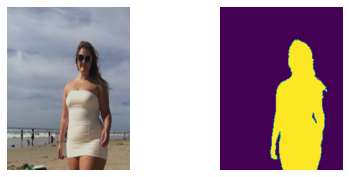

In [ ]:
# your code here
show_idx_image(train_dataset, 1)

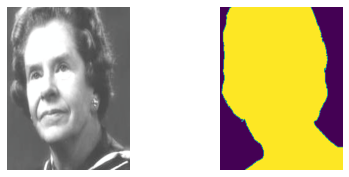

In [ ]:
# your code here
show_idx_image(train_dataset, 200)

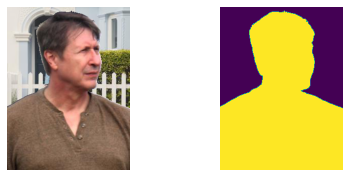

In [ ]:
# your code here
show_idx_image(train_dataset, 5)

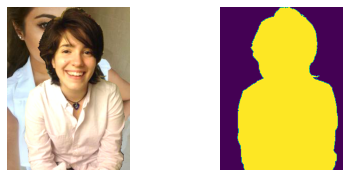

In [ ]:
# your code here
show_idx_image(train_dataset, 42)

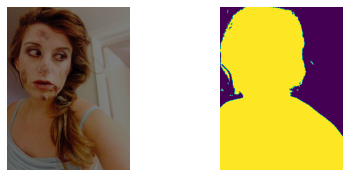

In [ ]:
# your code here
show_idx_image(train_dataset, 4)

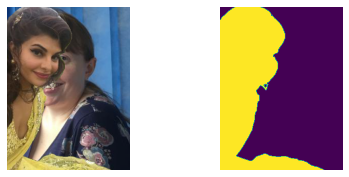

In [ ]:
# your code here
show_idx_image(train_dataset, 1000)

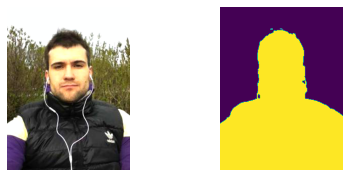

In [ ]:
# your code here
show_idx_image(train_dataset, 133)

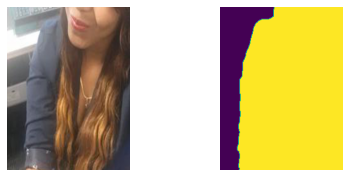

In [ ]:
# your code here
show_idx_image(train_dataset, 1300)

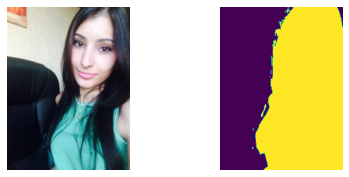

In [ ]:
# your code here
show_idx_image(train_dataset, 227)

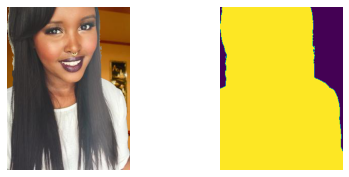

In [ ]:
# your code here
show_idx_image(train_dataset, 1337)

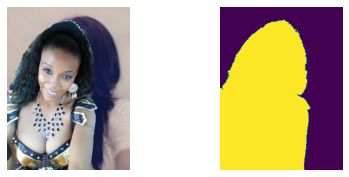

In [ ]:
# your code here
show_idx_image(train_dataset, 3)

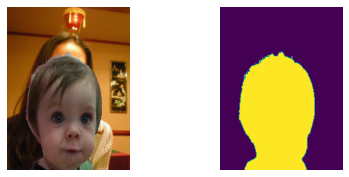

In [ ]:
# your code here
show_idx_image(train_dataset, 777)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        #true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        dice_loss_by_batches = 1 - 2 * (logits * true_labels).sum(axis=(1, 2)) / (logits.sum(axis=(1, 2)) + true_labels.sum(axis=(1, 2)) + self.eps * (logits.shape[1] + logits.shape[2]))
        # your code here
        
        if self.reduction == 'sum':
            loss_value = dice_loss_by_batches.sum()
        elif self.reduction == 'mean':
            loss_value = dice_loss_by_batches.mean()
        elif self.reduction is None:
            loss_value = dice_loss_by_batches
            
        return loss_value

Проверка реализации:

In [17]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
# Немного изменим функцию для более точного подсчета функции потерь и качества сегментации по эпохе, т. к. будем использовать средние значения лосса и метрики по батчу
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(net.device)
            
            outputs = net(images).cpu()
            total += labels.size(0)
            loss += criterion(outputs, labels).item() * labels.size(0)
            correct += val_criterion(outputs, labels).item() * labels.size(0)
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

Для удобства выделим обучение, оценивание и вывод результатов работы сети в отдельные функции, а зетем объединим их в один пайплайн для дальнейшего многократного использования. Напишем также  дополнительно callback для сохранения и вывода промежуточной информации.

In [ ]:
# your code here
def train(model,  train_dataloader, test_dataloader, criterion, num_epoch, optimizer, metric, callback=None):
    for epoch in range(num_epoch):
        processed = 0
        loss_sum = 0.0
        for (X_batch, y_batch) in train_dataloader:
            model.train()
            model.zero_grad()
            result = model(X_batch.to(model.device))
            batch_loss = criterion(result, y_batch.to(model.device))
            batch_loss.backward()
            optimizer.step()
            res = batch_loss.cpu().item()
            batch_size = len(X_batch)
            loss_sum += res * batch_size
            processed += batch_size        
        epoch_loss = loss_sum / processed
        if callback is not None:
            callback(model, epoch_loss)



In [ ]:
class CallBack:
    def __init__(self, num_epoch, val_func, dataloader, criterion, metric, device):
        self.num_epoch = num_epoch
        self.val_func = val_func
        self.dataloader = dataloader
        self.criterion = criterion
        self.metric = metric
        self.train_loss = []
        self.test_loss = []
        self.metrics = []
        self.device = device

    def __call__(self, model, train_loss):
        self.train_loss.append(train_loss)
        test_loss, metric = self.val_func(model, self.dataloader, self.criterion, self.metric, self.device)
        self.test_loss.append(test_loss)
        self.metrics.append(metric)

    def plot_stats(self):
        epochs = np.arange(self.num_epoch) + 1
        plt.figure(figsize=(18, 15))
        plot1 = plt.subplot(2, 1, 1)
        plot1.set_title('Losses on train and test')
        plot1.set_xlabel('Epoch number')
        plot1.set_ylabel('Loss')
        plot1.plot(epochs, self.train_loss, label='Loss on train')
        plot1.plot(epochs, self.test_loss, label='Loss on test')
        plot1.grid(True)
        plot1.legend()

        plot2 = plt.subplot(2, 1, 2)
        plot2.set_title('IoU on test')
        plot2.set_xlabel('Epoch number')
        plot2.set_ylabel('IoU')
        plot2.plot(epochs, self.metrics)
        plot2.grid(True)
        plot2.legend()

        plt.tight_layout()

In [ ]:
def plot_results(model, dataloader):
    print('Examples of network results')
    model.eval()
    X_batch, y_batch = next(iter(dataloader))
    with torch.no_grad():
        result = model(X_batch.to(model.device)).cpu()
    scores = torch.sigmoid(result)
    batch_size = len(X_batch)
    plt.figure(figsize=(18, 15))
    for sample in range(batch_size):
        plt.subplot(batch_size, 3, sample * 3 + 1)
        plt.imshow(X_batch[sample].squeeze().permute(1, 2, 0))
        plt.axis('off')

        plt.subplot(batch_size, 3, sample * 3 + 2)
        plt.imshow(y_batch[sample].squeeze())
        plt.axis('off')

        plt.subplot(batch_size, 3, sample * 3 + 3)
        plt.imshow(scores[sample].squeeze())
        plt.axis('off')
    plt.tight_layout()

В качестве метрики качества сегментации будем использовтаь IoU.

In [ ]:
class IoU(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):  
        if self.with_logits:
            logits = torch.sigmoid(logits)
        positive_preds = logits > 0.5
        positive_true = true_labels.bool()
        iou_by_batches = ((positive_preds & positive_true).sum(axis=(1, 2)) + self.eps) / ((positive_preds | positive_true).sum(axis=(1, 2)) + self.eps)
        if self.reduction == 'sum':
            loss_value = iou_by_batches.sum()
        elif self.reduction == 'mean':
            loss_value = iou_by_batches.mean()
        elif self.reduction is None:
            loss_value = iou_by_batches
        return loss_value

In [ ]:
def pipeline(model, criterion, num_epoch, train_dataloader, test_dataloader, metric):
    model = model()
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    device = torch.device(device)
    model.to(device)
    model.device = device
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    cb = CallBack(num_epoch, evaluate_net, test_dataloader, criterion, metric, device)
    train(model, train_dataloader, test_dataloader, criterion, num_epoch, optimizer, metric, cb)
    plot_results(model, test_dataloader)
    return cb

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import time

Обучим сеть с кросс-энтропией в качестве функции потерь.

Examples of network results


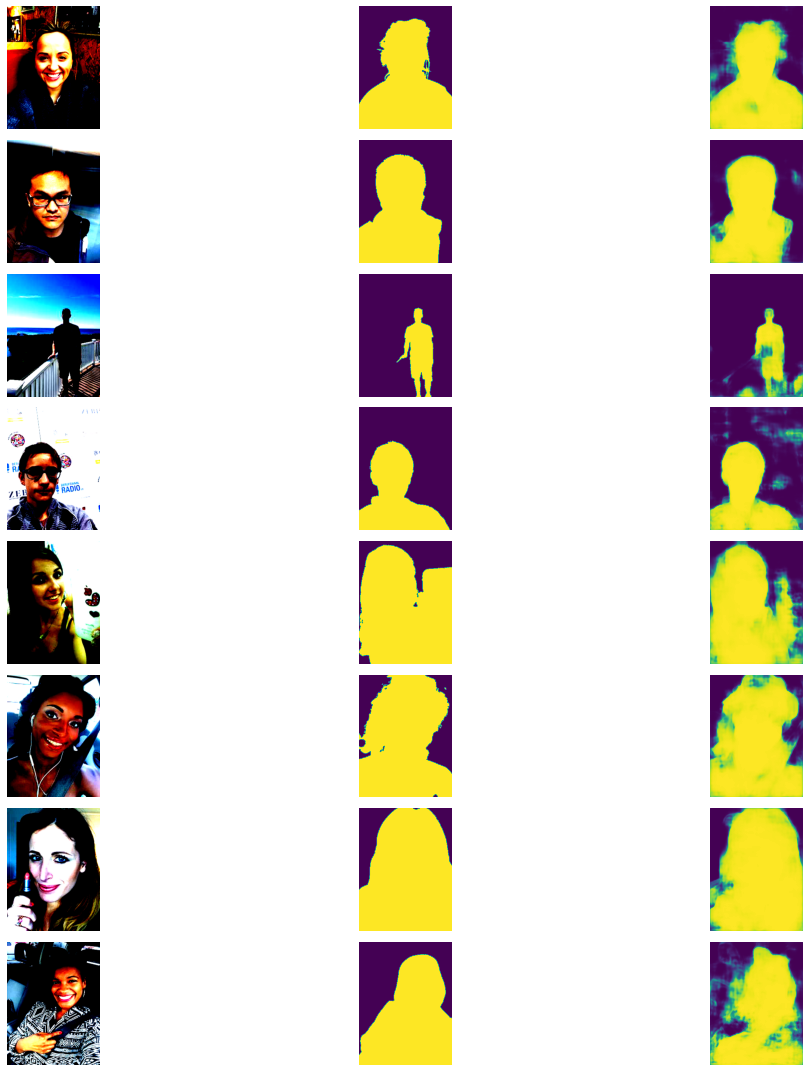

In [ ]:
start = time.time()
results = pipeline(UNet, torch.nn.BCEWithLogitsLoss(reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

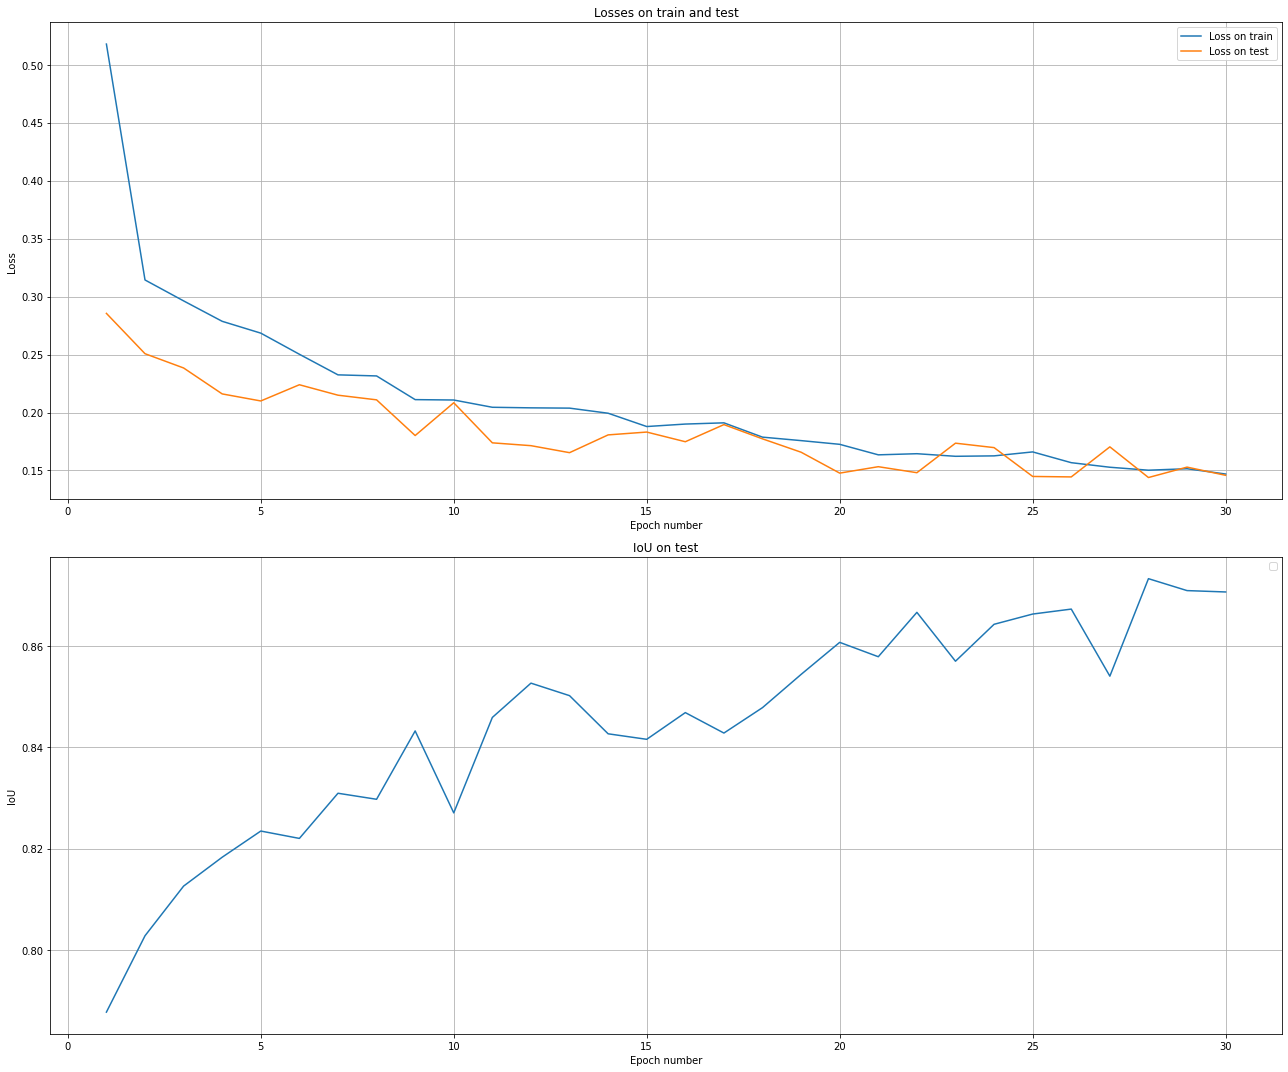

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2485.7546787261963
Best loss on train: 0.1469408177998331
Best loss on test: 0.1439277487972104
Best IoU on test: 0.8732347002266146


В целом сеть достаточно быстро достигает малого значения потерь и довольно высокого качества сегментации: 0.8 и более. Убывание потерь и возрастание метрики качества в целом монотонное. Стоит отметить, что почти все время потери на обучении выше потерь на тесте. Это может быть связано с тем, что на обучении используется аугментация изображений, в которой, в том числе, в качестве фона может быть другое изображение с человеком, и могут применяться несколько преобразований вместе. На тестовой же выборке аугментация не применяется. На результатах работы сети видны размытые нечеткие области вокруг основной маски, но в целом изображения близки к истинным маскам.

Проведем обучение с функцией DiceLoss.

Examples of network results


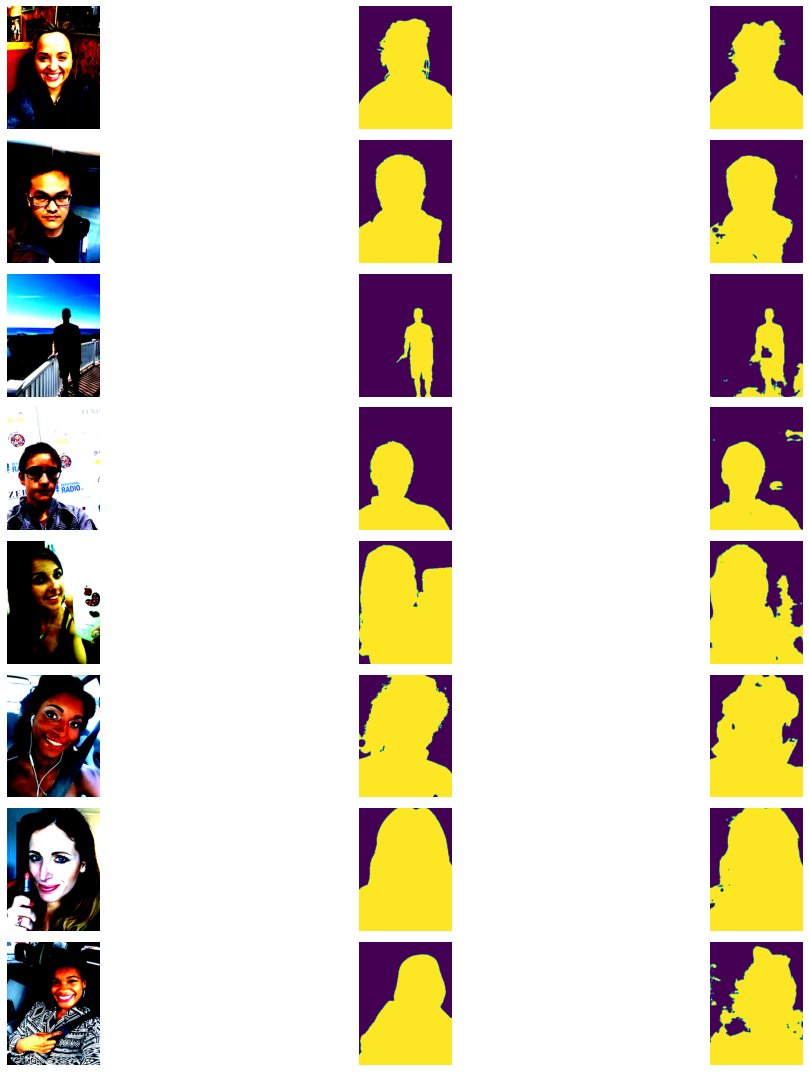

In [ ]:
start = time.time()
results = pipeline(UNet, DiceLoss(reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

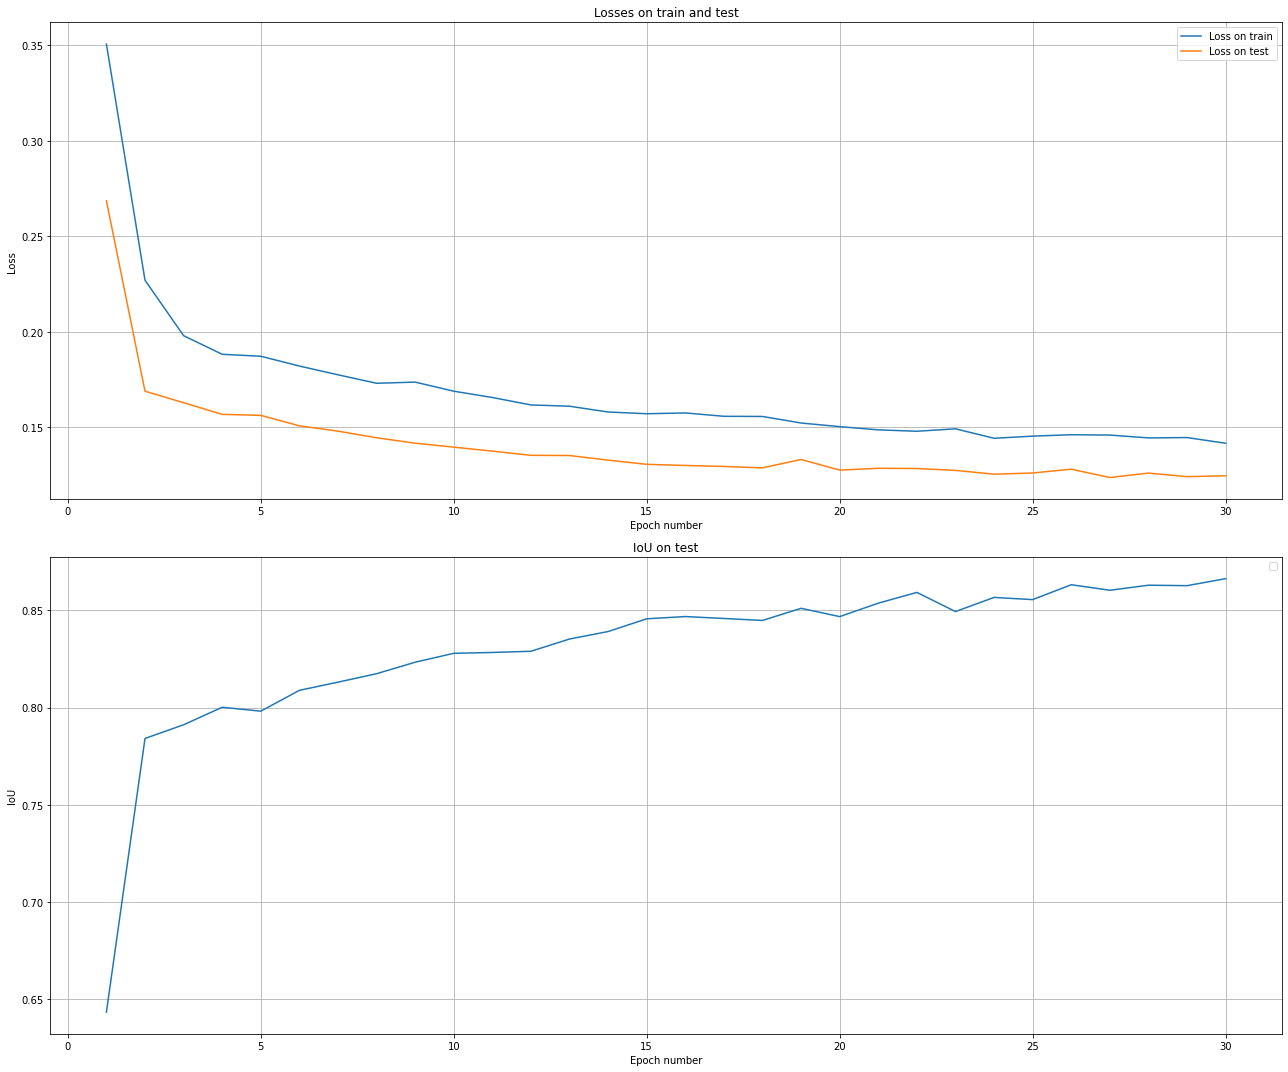

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2481.563373565674
Best loss on train: 0.14167146305243175
Best loss on test: 0.12373162277624117
Best IoU on test: 0.8662776021247215


На тесте наименьшее значение потерь незначительно меньше, чем в случае кросс-энтропии, лучшее качество сегментации немного ниже. Потери на обучении все также больше, чем на тесте, но графики более гладкие и начинают заметно убывать раньше. График качества сегментации так же более гладкий. Время обучения примерно такое же, как и в предыдущем случае. Выходные изображения более четкие, с меньшим числом размытых участков, но присутствуют различные артефакты в виде лишних объектов или "дыр", изрезанных границ. Возможно, можно было бы получить лучшие результаты при других значениях темпа обучения и т. д.

Стоит отметить, что при использовании больших значений темпа обучения ($10^{-3}$) сеть практически не обучалась, выходы были почти полностью черными изображениями. В случае кросс-энтропии такого эффекта не наблюдалось.

Рассмотрим комбинацию кросс-энтропии и DiceLoss. Будем брать их взвешенную сумму. Для простоты рассмотрим комбинацию с коэффициентами 0.5.

In [ ]:
class Combination:
    def __init__(self, proportion, reduction):
        self.proportion = proportion
        self.cross_entropy = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.dice_loss = DiceLoss(reduction=reduction)
        
    def __call__(self, result, targets):
        return self.proportion * self.cross_entropy(result, targets) + (1 - self.proportion) * self.dice_loss(result, targets)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

Examples of network results


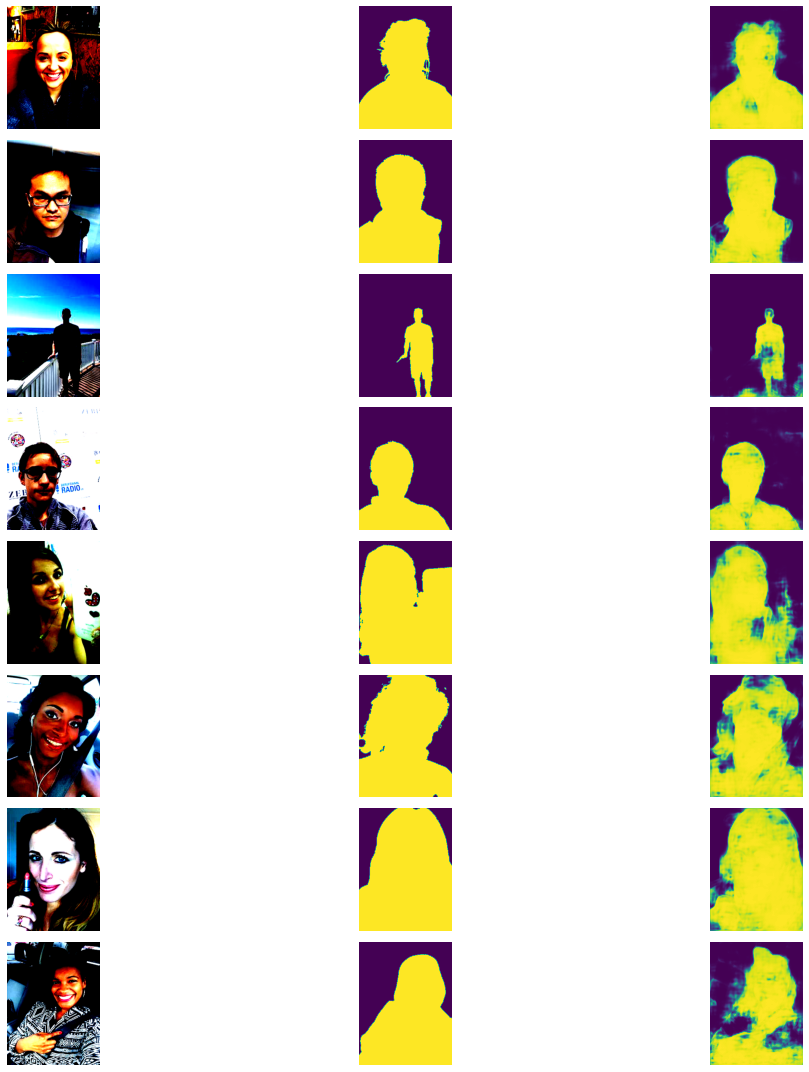

In [ ]:
start = time.time()
results = pipeline(UNet, Combination(proportion=0.5, reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

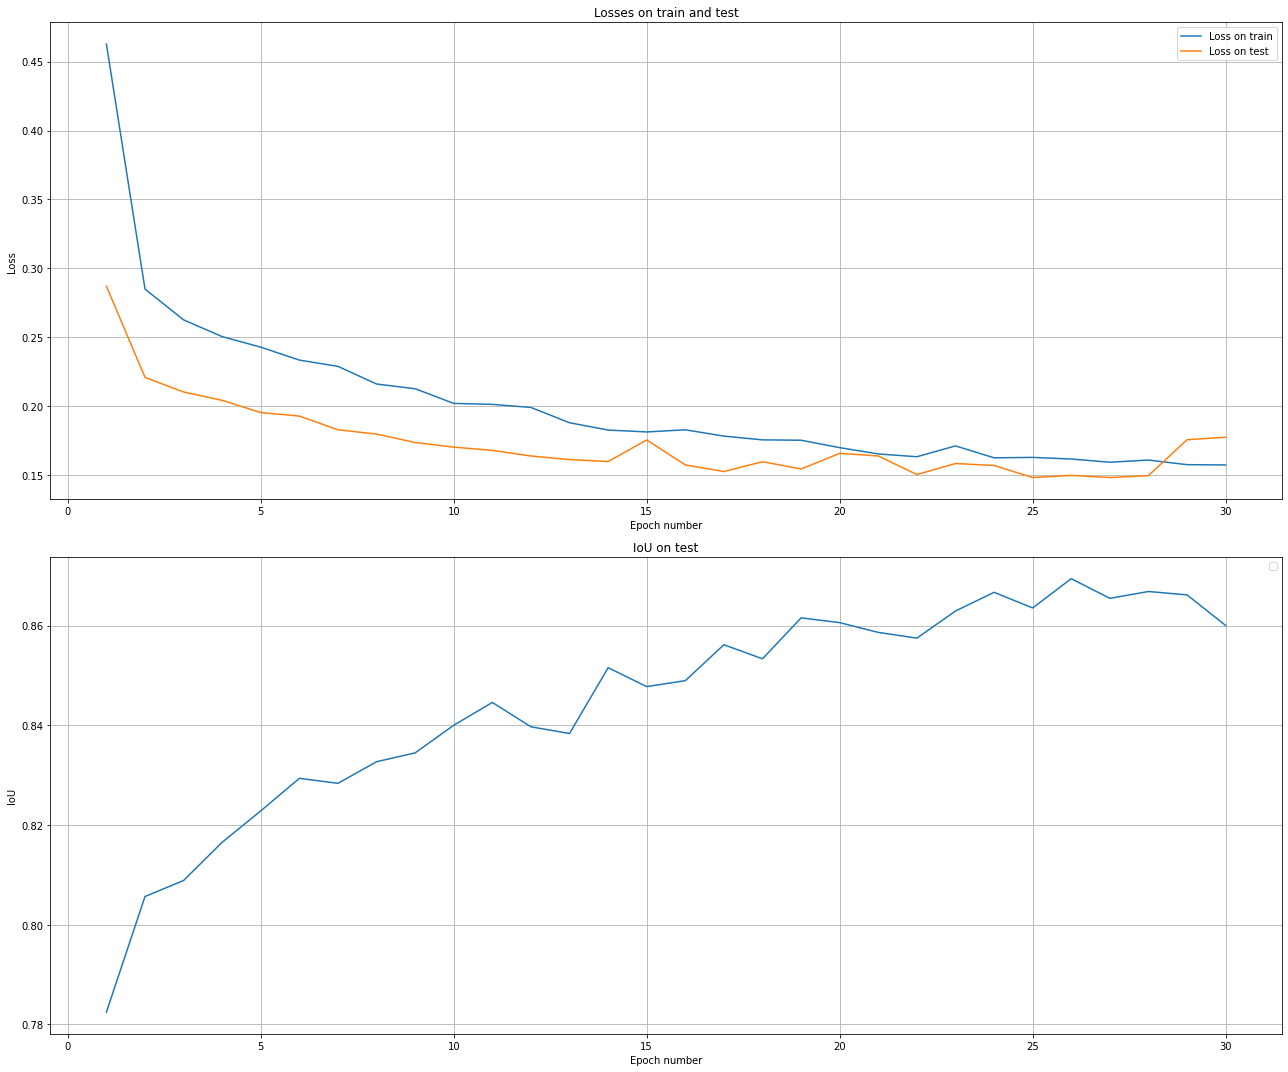

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2528.689534664154
Best loss on train: 0.157341633549443
Best loss on test: 0.14820660745843928
Best IoU on test: 0.8694029695598792


Немного возросло время обучения, наименьшие значения потерь чуть больше, наилучшее качество лучше, чем для DiceLoss, но хуже, чем для кросс-энтропии, хотя в целом они довольно близки. На обучении потери по прежнему выше, чем на тесте, графики более гладкие, чем для кросс-энтропии, но менее гладкие, чем для DiceLoss. Также на последних эпохах наблюдается небольшое падение качества. На получаемых изображениях есть размытые участки, но в меньшей степени, чем для кросс-энтропии, артефактов меньше, чем для DiceLoss. Можно предположить, что варьируя коэффициенты при функциях потерь в комбинации, можно получать более удовлетворительные результаты, улучшая в сторону большего значения метрики качества или большей четкости выходной маски соотвтетсвенно. Также могут помочь большее число эпох и другие значения темпа обучения, в том числе и адаптивные, уменьшающиеся с ростом числа эпох, для устранения падения качества на поздних эпохах.

В итоге лучшее качество сегментации было достигнуто при использовании кросс-энтропии, но изображения получились нечеткими. При использовании DiceLoss потери несколько меньше, качество сегментации чуть ниже, изображения четче, но с наличием артефактов. Вероятно комбинация двух функций с подбором коэффициентов и гиперпараметров сможет дать наилучшие результаты.

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [ ]:
# your code here
class DecoderBlockLinkNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(left + x))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class DecoderLinkNet(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlockLinkNet(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x


Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

Обучим сеть с кросс-энтропией.

Examples of network results


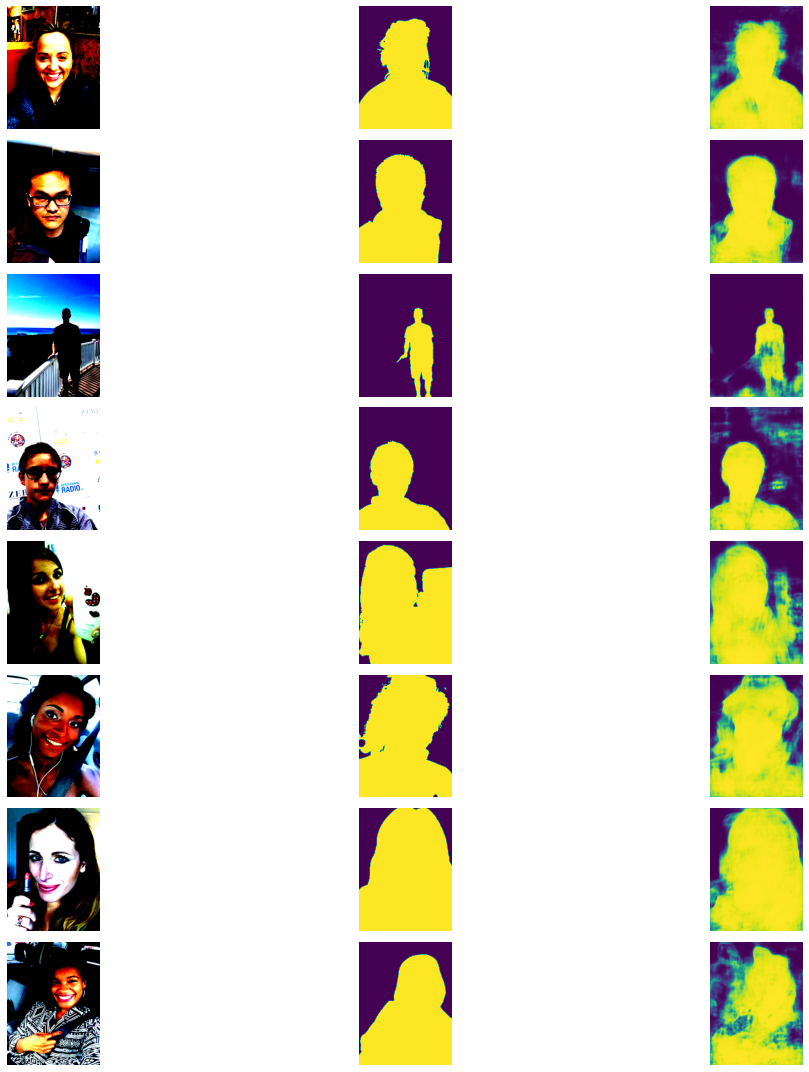

In [ ]:
start = time.time()
results = pipeline(LinkNet, torch.nn.BCEWithLogitsLoss(reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

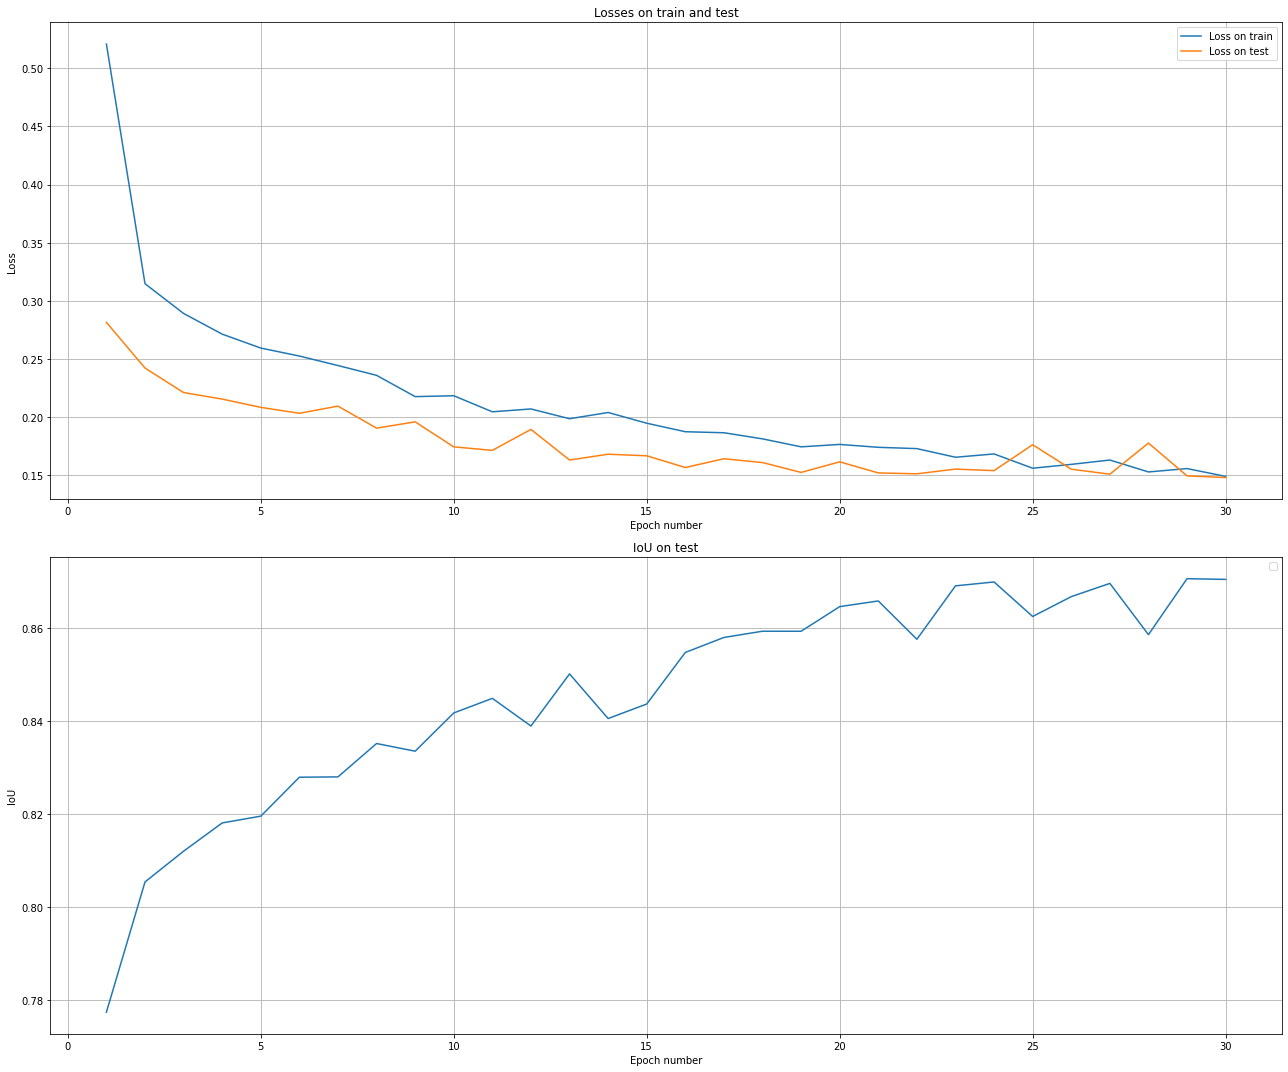

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2536.6606075763702
Best loss on train: 0.14910833494530784
Best loss on test: 0.1481221115335505
Best IoU on test: 0.8705353665013685


Время обучения чуть выше, чем для UNet, лучшие потери на обучении и тесте примерно такие же, наилучшее качество сегментации незначительно меньше. Потери на обучении так же больше, чем на тесте, но в целом графики более гладкие. На итоговых изображениях аналогично есть размытые области. Результаты в целом схожи с результатами UNet.

Рассмотрим функцию DiceLoss.

Examples of network results


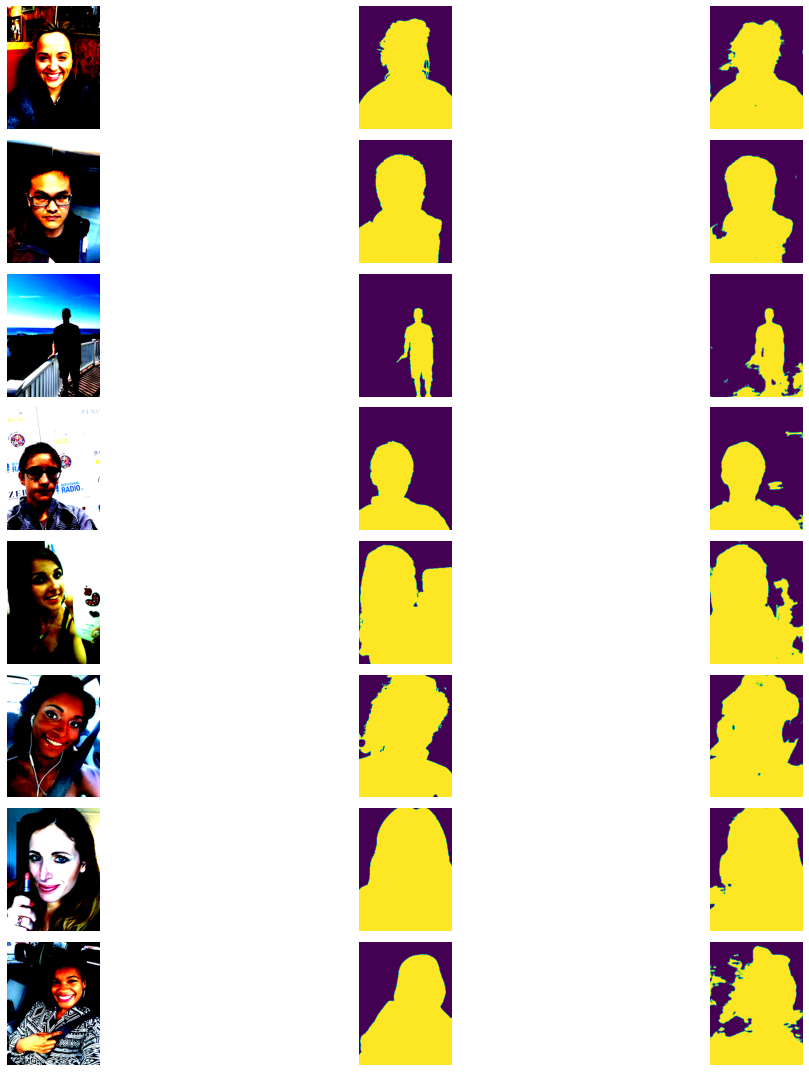

In [ ]:
start = time.time()
results = pipeline(LinkNet, DiceLoss(reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

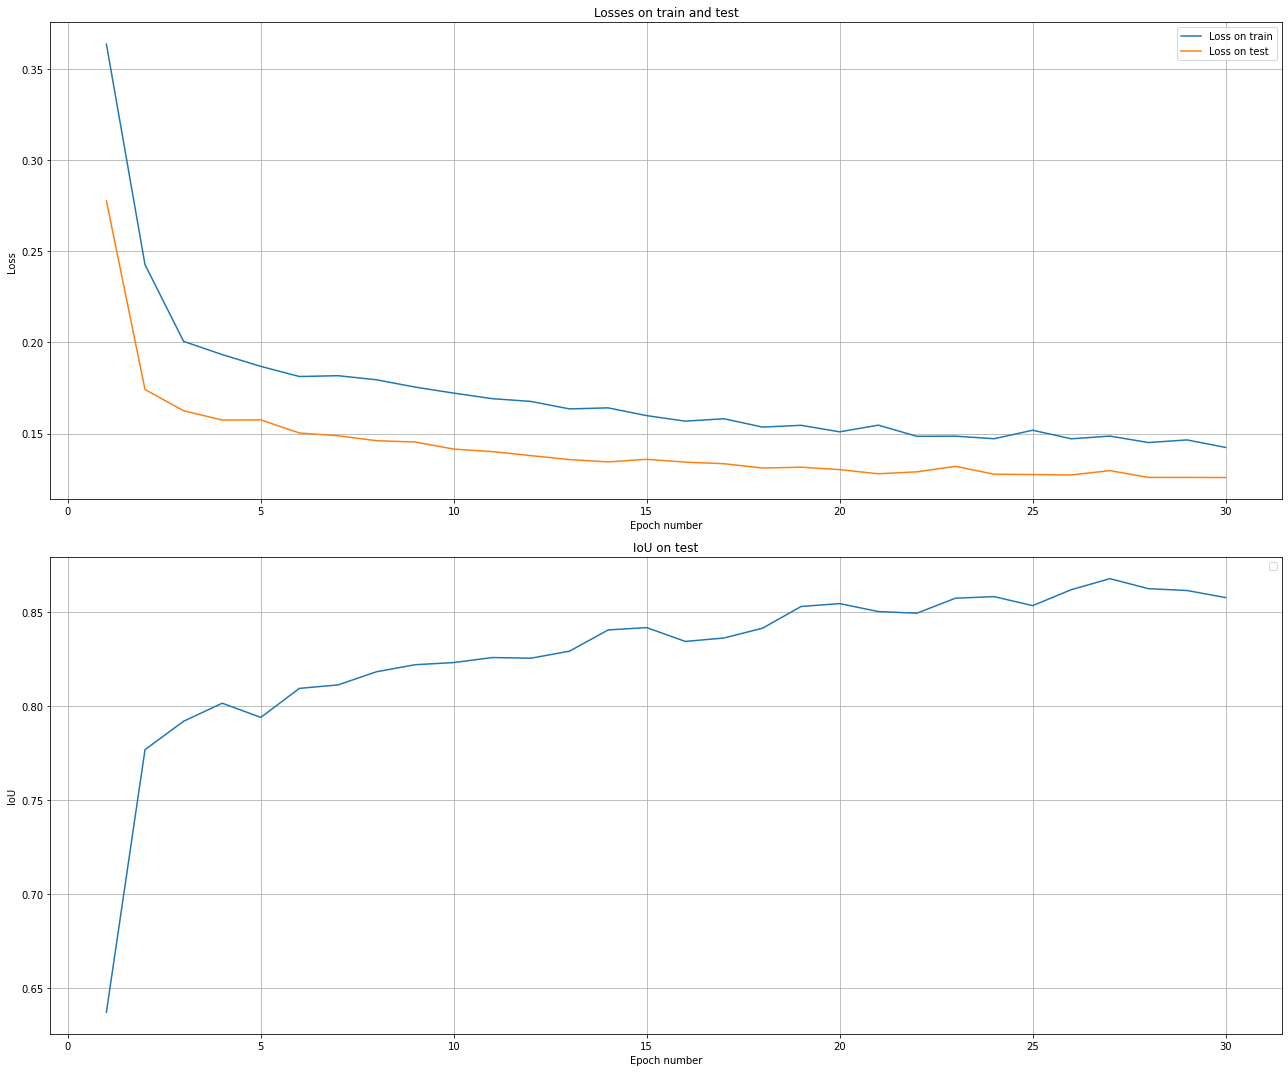

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2529.715761423111
Best loss on train: 0.14237093439808599
Best loss on test: 0.12585430269968426
Best IoU on test: 0.8677315648565901


Результаты очень близки к аналогичным результатам для UNet, лучшее качество чуть выше, время обучения больше, наименьшие потери в целом такие же. Графики весьма стабильные, потери на обучении выше потерь на тесте. Выходные изображения довольно четкие, и артефактов визуально меньше, чем для UNet.

Обучим с комбинацией функций, коэффициент возьмем аналогично равный 0.5.

Examples of network results


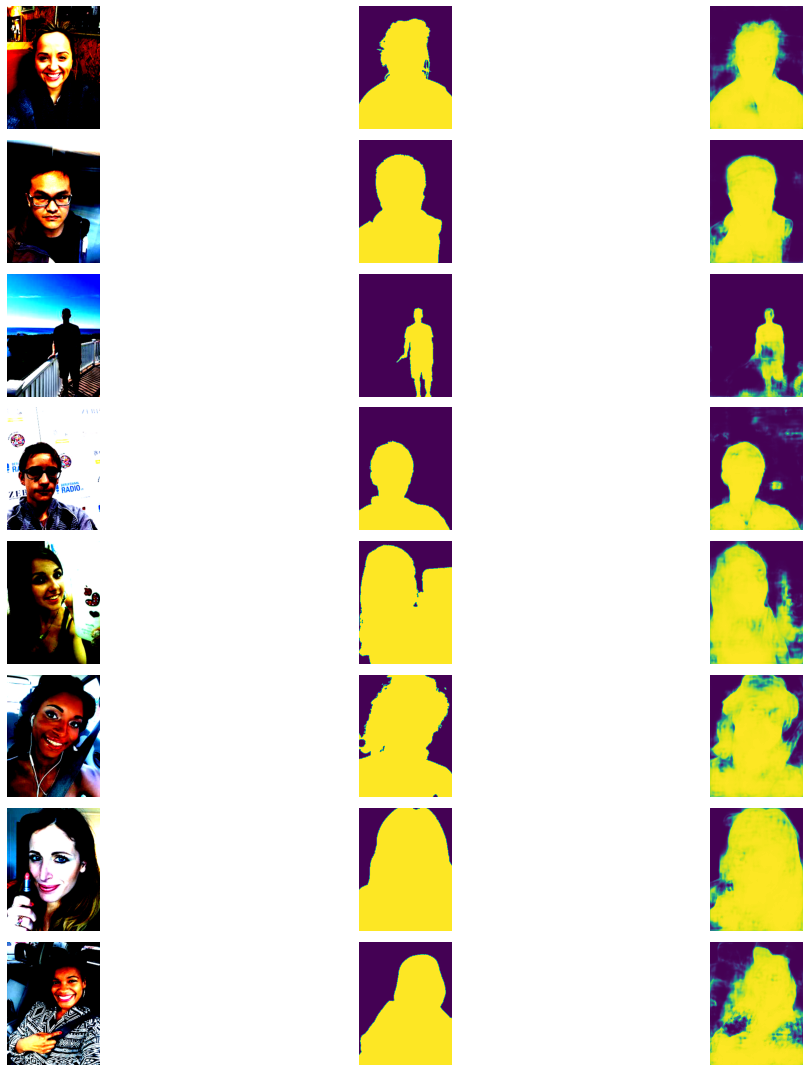

In [ ]:
start = time.time()
results = pipeline(LinkNet, Combination(proportion=0.5, reduction='mean'), 30, train_data_loader, test_data_loader, IoU(reduction='mean'))
end = time.time() - start

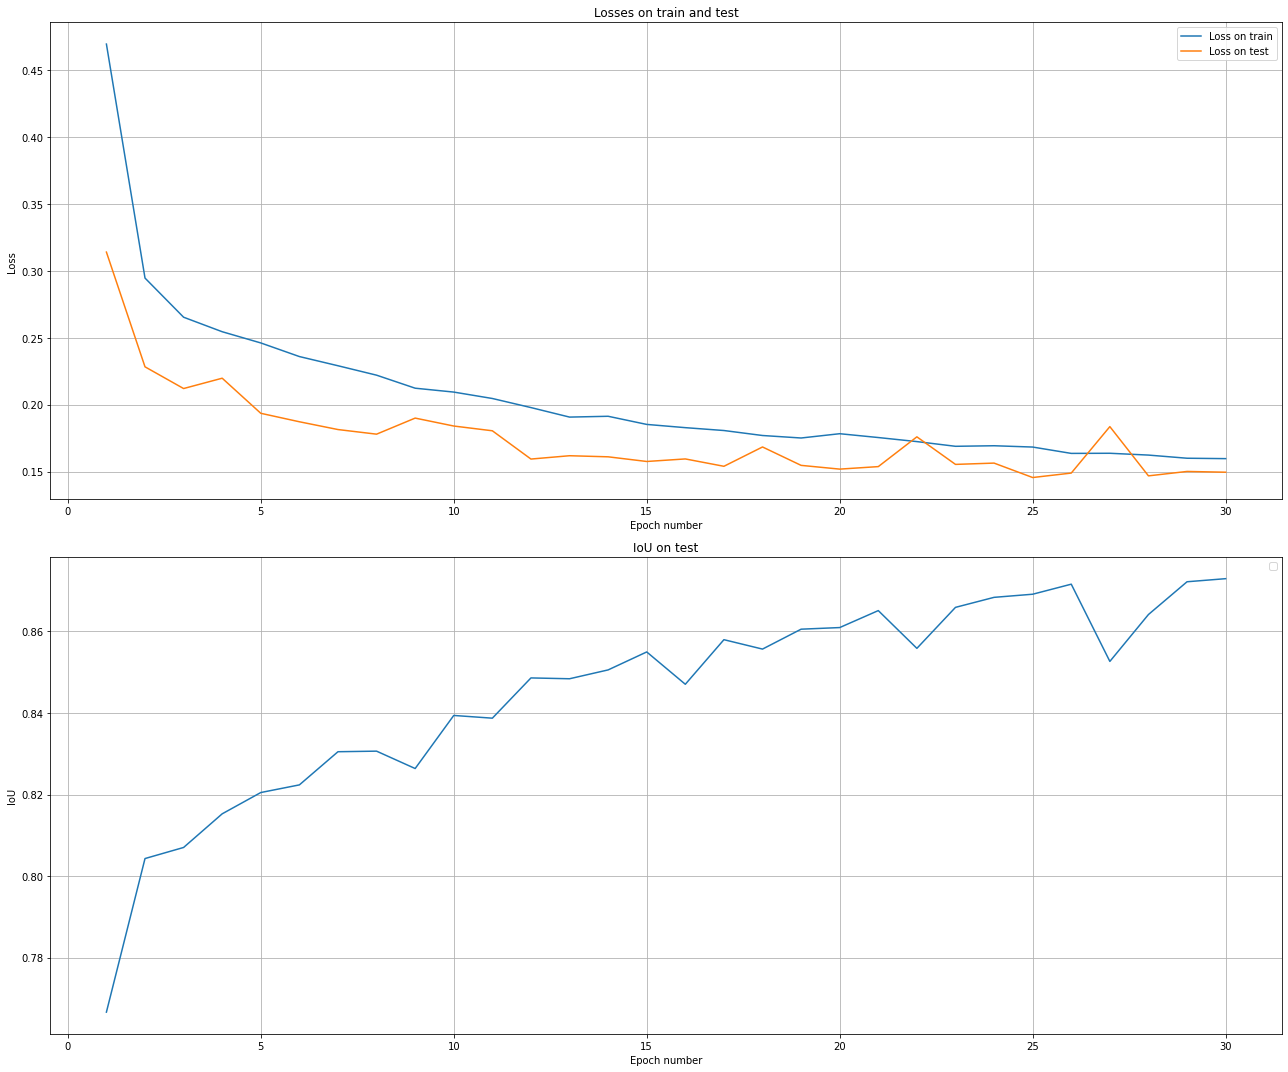

In [ ]:
results.plot_stats()

In [ ]:
print(f'Training time: {end}')
print(f'Best loss on train: {min(results.train_loss)}')
print(f'Best loss on test: {min(results.test_loss)}')
print(f'Best IoU on test: {max(results.metrics)}')

Training time: 2536.739516735077
Best loss on train: 0.15964942510481234
Best loss on test: 0.14552268269636953
Best IoU on test: 0.8729043683261736


Лучшее качество немного больше, чем для UNet, время обучения больше, но близко ко времени обучения UNet, потери примерно такие же. Графики немного менее стабильные, но не наблюдается падения качества на последних эпохах. Получаемые изображения размыты по краям, артефактов визуально немного. Результаты в целом похожи на UNet. Опять же, при других значениях коэффициентов и гиперпараметров возможно могут быть достигнуты результаты лучше.

В целом, результаты для обеих архитектур близки, заметное отличие - время обучения, UNet обучается немного быстрее LinkNet, на 1 эпоху затрачивается на 5-10 секунд меньше. При использовании DiceLoss получаются более четкие изображения, но с артефактами, убывание потерь и рост качества начинаются раньше, и их графики более стабильны. Комбинация кросс-энтропии и DiceLoss может использовтаься для получения лучших изображений в зависимости от приоритета четкости изображения или отсутствия дыр и лишних участков, целостности изображения.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

Во входных данных участки, позволяющие выделить объект или провести классификацию и т. д., должны иметь определенную структуру, и предполагается некоторая компактность и локальность ключевых объектов, то есть определяющая структура сосредоточена в конкретной области изображения. Таким образом, интересующая нас информация будет распределена не по всему изображению, а где-то локально, и поэтому использование свертки будет уместным для агрегации информации из расположенных близко пикселей (например, детекция ребер, границ, конкретных геометрических форм и т. д.). 

Также в данных должна быть конкретная структура. Например, некоторый интересующий тип объектов для классификации имеет определенную форму, границу, его определяет конкретная геометрия и похожие повторяющиеся участки. В таком случае уместно применять одну свертку с конкретным ядром, например для выделения вертикальных полос и т. д.

Если эти предположения выполнены, то применение сверток позволяет снизить число параметров, т. к. нет нужды в таком случае использовать полносвязную сеть для сбора информации по всему изображению. Это позволяет обучаться быстрее и эффективно бороться с переобучением, избежать влияния шумовых и далеких пикселей, получать более устойчивый к шумам результат. 

В качестве примеров данных, для которых эти предположения не выполнены, могут выступать изображения без четкой структуры, размытые, с большим числом разрозненных схожих мелких или нечетких паттернов, или просто очень большие изображения с большим числом относительно мелких объектов. Например, пестрый и неструктурированный орнамент с большим числом перемешанных примитивов, с гладкими и неповторяющимися формами. Важная информация на нем рассредоточена по всей площади, нет четкой структуры расположения объектов, и они нечеткие и неповторяющиеся, а также размера свертки может не хватить для выделения ключевого паттерна в случае большого размера изображения.  

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Функция $f(\cdot)$:

-Размерность выходного пространства: 1000

-Количество обучаемых параметров: 1000*100=100000 (веса $W$)

-Число операций при forward pass: 1000 * 100=100000 умножений, 99 * 1000 = 99000 сложений, 1000 применений функции $\sigma(\cdot)$

Функция $g(\cdot)$:

-Размерность выходного пространства: 100 $\times$ 10

-Количество обучаемых параметров: 3 * 10 = 30 (входы и свертка - одномерные)

-Число операций при forward pass: 3 * 100 * 10 = 3000 умножений, 2 * 100 * 10 =2000 сложений, 1000 применений функции $\sigma(\cdot)$ (учитывая паддинг)

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).